# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

In [1]:
import functools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split as tts
from sklearn import preprocessing as pr
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import metrics
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.learning_curve import learning_curve
import warnings
import xgboost as xgb
warnings.simplefilter('ignore')

%matplotlib inline

def get_numerical_features(sdata):
    features = set(sdata.columns) & set([("Var%d" % i) for i in range(1, 191)])
    return list(features)


def get_categorial_features(sdata):
    features = set(sdata.columns) & set([("Var%d" % i) for i in range(191, 231)])
    return list(features)


def get_kaggle_data():
    # считываем данные
    churn_train_data = pd.read_csv('churn_train_data.csv')
    labels = churn_train_data['labels']
    churn_train_data = churn_train_data.drop(['labels', 'ID'], axis=1)
    churn_test_data = pd.read_csv('churn_test_data.csv')
    churn_test_data = churn_test_data.drop(['ID'], axis=1)
    return churn_train_data, labels, churn_test_data


def write_ans(values, file_name = None):
    if file_name is None:
        file_name = 'ans.csv'
    # функция записи ответа
    with open(file_name, 'w') as il:
        il.write('ID,result\n')
        for (idx, element) in enumerate(values):
            il.write(str(idx))
            il.write(str(","))
            il.write(str(round(element, 10)))
            il.write('\n')

/Users/vgridnev/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/vgridnev/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
def process_numerical_features(sdata, ndata, fill_zero = None):
    features = get_numerical_features(sdata)
    for (idx, feature) in enumerate(features):
        non_na = np.array(sdata[feature].dropna())
        mean = non_na.mean()
        if fill_zero:
            sdata[feature].fillna(0, inplace=True)
            ndata[feature].fillna(0, inplace=True)
        else:
            sdata[feature].fillna(mean, inplace=True)
            ndata[feature].fillna(mean, inplace=True)

    return sdata[features].as_matrix(), ndata[features].as_matrix()


def remove_incomplete_features(sdata, ndata, features):
    to_remove = set()
    for feature in features:
        nan_part = sum(sdata[feature].isnull()) / float(sdata.shape[0])
        if nan_part > 0.9:
            sdata = sdata.drop(feature, axis=1)
            ndata = ndata.drop(feature, axis=1)
            to_remove.add(feature)    
    return sdata, ndata


def apply_str(data):
    features = get_categorial_features(data)
    for feature in features:
        data[feature] = data[feature].apply(lambda x: str(x))
    return data[features]


def one_hot(sdata, ndata):
    encoder = DV(sparse = False)
    sdata = encoder.fit_transform(sdata.T.to_dict().values())
    ndata = encoder.transform(ndata.T.to_dict().values())
    return sdata, ndata


def label_encoder(sdata, ndata):
    features = get_categorial_features(sdata)
    for feature in features:
        # применяем LabelEncoder на все строки
        encoder = pr.LabelEncoder()
        values = set(sdata[feature].values) | set(ndata[feature].values)
        encoder.fit(list(values))
        sdata[feature] = encoder.transform(sdata[feature])
        ndata[feature] = encoder.transform(ndata[feature])
    return sdata.as_matrix(), ndata.as_matrix()


def filter_drop_less(sdata, ndata, **kwargs):
    drop_less = kwargs.get('drop_less', 0)
    features = get_categorial_features(sdata)
    for feature in features:
        vcounts = sdata[feature].value_counts()
        sdata[feature] = sdata[feature].apply(lambda x: 'nan' if vcounts.get(x, 0) < drop_less else x)
        ndata[feature] = ndata[feature].apply(lambda x: 'nan' if vcounts.get(x, 0) < drop_less else x)
    return sdata, ndata


def filter_by_top(sdata, ndata, **kwargs):
    top = kwargs.get('top', 10)
    features = get_categorial_features(sdata)
    for feature in features:
        vcounts = sdata[feature].value_counts()
        vcounts = [(-vcounts[x], x) for x in vcounts.keys()]
        vcounts = sorted(vcounts, key = lambda x: x[0])
        vcounts = vcounts if len(vcounts) < top else vcounts[:top]
        vcounts = set([name for cnt, name in vcounts])
        
        sdata[feature] = sdata[feature].apply(lambda x: x if x in vcounts else 'nan')
        ndata[feature] = ndata[feature].apply(lambda x: x if x in vcounts else 'nan')
    return sdata, ndata


def process_categorial_features(sdata, ndata, filter_strategy = None, 
                                feature_encoder = None, **kwargs):
    sdata, ndata = apply_str(sdata), apply_str(ndata)
    features = get_categorial_features(sdata)
    for feature in features:
        if len(set(sdata[feature].values)) == 1:
            # удаляем постоянные признаки
            sdata = sdata.drop(feature, axis=1)
            ndata = ndata.drop(feature, axis=1)
    
    filter_method = filter_by_top if filter_strategy == 'top' else filter_drop_less
    sdata, ndata = filter_method(sdata, ndata, **kwargs)
    
    features = get_categorial_features(sdata)
    sdata, ndata = sdata[features], ndata[features]
    
    feature_encoder = one_hot if feature_encoder == 'one_hot' else label_encoder
    sdata, ndata = feature_encoder(sdata, ndata)

    return sdata, ndata


def prepare_train_data(sdata, ndata, labels, fill_zero = False, remove_incomplete = False, **kwargs):
    if remove_incomplete:
        # удаляем фичи в которых большее количество пустых ячеек
        sdata, ndata = remove_incomplete_features(sdata, ndata, list(sdata.columns))
    
    # обрабатываем численные фичи
    numerical_train_data, numerical_test_data = process_numerical_features(
        sdata, ndata, fill_zero = fill_zero)

    # обрабатываем категориальные признаки
    categorial_train_data, categorial_test_data = process_categorial_features(
        sdata, ndata, **kwargs)

    prepared_train_data = np.concatenate([
            numerical_train_data, categorial_train_data], axis=1)
    prepared_test_data = np.concatenate([
            numerical_test_data, categorial_test_data], axis=1)   
    return prepared_train_data, np.array(labels), prepared_test_data


def get_estimator(depth = 3, n_estimators = 100):
    return xgb.XGBClassifier(
        learning_rate=0.1, max_depth = 3, seed = 42, n_estimators = n_estimators, min_child_weight = 10)


churn_train_data, labels, churn_test_data = get_kaggle_data()
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = True,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

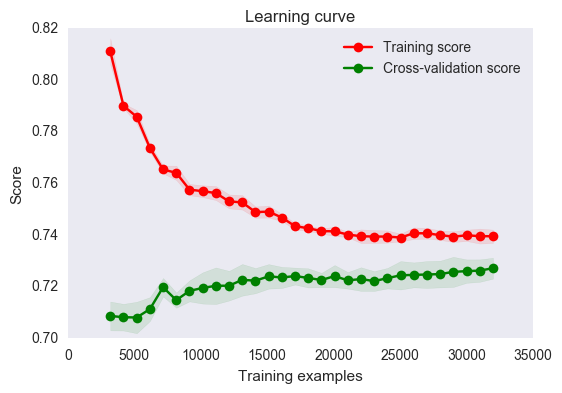

In [3]:
def plot_learning_curve(estimator, X, y):
    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1, 30), 
        scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(get_estimator(n_estimators = 30), X, y)

**Будем обучать модель на 30000 - 35000 элементах, так как качество на кросс-валидации растет**

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

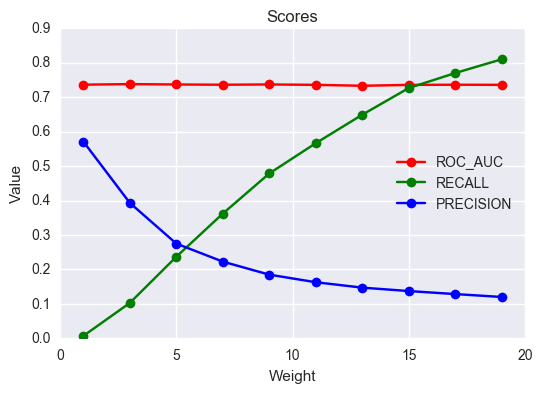

In [7]:
X_train, X_test, y_train, y_test = tts(X, y, random_state = 42, train_size = 25000)
weights_sequence = range(1, 21, 2)
precision, recall, roc_auc = [], [], []
for weight in weights_sequence:
    weights = [1 if y_train[x] == -1 else weight for x in range(X_train.shape[0])]
    est = get_estimator(n_estimators = 100)
    est.fit(X_train, y_train, sample_weight = weights)
    pred = est.predict(X_test)
    values = est.predict_proba(X_test)[:,1]
    
    roc_auc.append(metrics.roc_auc_score(y_test, values))
    recall.append(metrics.recall_score(y_test, pred))
    precision.append(metrics.precision_score(y_test, pred))

plt.figure()
plt.title("Scores")
plt.xlabel("Weight")
plt.ylabel("Value")
plt.plot(weights_sequence, roc_auc, 'o-', color="r",
         label="ROC_AUC")
plt.plot(weights_sequence, recall, 'o-', color="g",
         label="RECALL")
plt.plot(weights_sequence, precision, 'o-', color="b",
         label="PRECISION")
plt.legend(loc="best")
plt.show()

**При увеличении веса, логично что Recall значение возрастает, но при этом страдает точность, при этом roc_auc почти не меняется. Поскольку нам в первую очередь нужно предсказывать отток-пользователей, следует выбрать в качестве веса значение 15.**

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

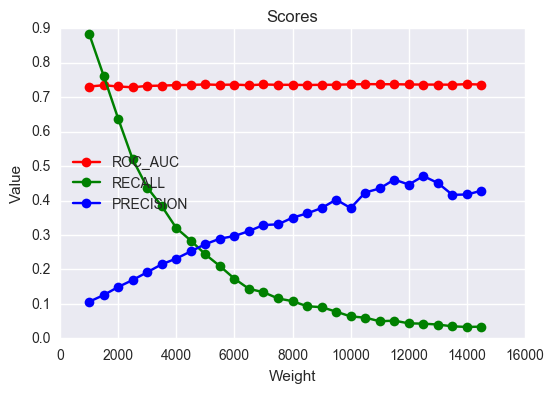

In [10]:
X_train, X_test, y_train, y_test = tts(X, y, random_state = 42, train_size = 25000)
precision, recall, roc_auc = [], [], []
for size in range(1000, 15000, 500):
    np.random.seed(0)
    indices = filter(lambda x: y_train[x] < 0, range(y_train.shape[0]))
    not_churn_indices = np.array([np.random.choice(indices) for _ in range(size)])
    churn_indices = filter(lambda x: y_train[x] > 0, range(y_train.shape[0]))
    Xt = np.concatenate([
                X_train[not_churn_indices,:],
                X_train[churn_indices,:],
            ], axis=0)
    yt = np.concatenate([
                y_train[not_churn_indices],
                y_train[churn_indices],    
            ], axis=0)
    est = get_estimator(n_estimators = 100)
    est.fit(Xt, yt)
    pred = est.predict(X_test)
    values = est.predict_proba(X_test)[:,1]
    
    roc_auc.append(metrics.roc_auc_score(y_test, values))
    recall.append(metrics.recall_score(y_test, pred))
    precision.append(metrics.precision_score(y_test, pred))

plt.figure()
plt.title("Scores")
plt.xlabel("Weight")
plt.ylabel("Value")
plt.plot(range(1000, 15000, 500), roc_auc, 'o-', color="r",
         label="ROC_AUC")
plt.plot(range(1000, 15000, 500), recall, 'o-', color="g",
         label="RECALL")
plt.plot(range(1000, 15000, 500), precision, 'o-', color="b",
         label="PRECISION")
plt.legend(loc="best")
plt.show()

**Выводы аналогичны пред. пункту. Выбрать вес гораздо проще, будем пользоваться именно такой стратегией.**

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [30]:
est = get_estimator(n_estimators = 100)

# Заполнение нулями

churn_train_data, labels, churn_test_data = get_kaggle_data()
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = True,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)
cv = cross_validation.StratifiedKFold(y, random_state = 42, n_folds = 5)
values = cross_validation.cross_val_score(est, X, y, cv = cv, scoring = 'roc_auc')
print(values)
print(values.mean())

# Заполнение средним

X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)
values = cross_validation.cross_val_score(est, X, y, cv = cv, scoring = 'roc_auc')
print(values)
print(values.mean())

[ 0.73624535  0.74385136  0.7458617   0.73070047  0.74767307]
0.740866390239
[ 0.73624535  0.74385136  0.7458617   0.73070047  0.74767307]
0.740866390239


**Ожидаемо, никакой разницы чем заполнять пустые значения в таблице числовых признаков нет, так как используются решающие деревья.**

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
est = get_estimator(n_estimators = 100)
cv = cross_validation.StratifiedKFold(y, random_state = 42, n_folds = 3)

# Label, Drop Less

cv_scores = []
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'label',
    drop_less = 0)
values = cross_validation.cross_val_score(est, X, y, cv = cv, scoring = 'roc_auc')
print(values.mean())

# One-Hot, Drop Less
cv_scores = []
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)
values = cross_validation.cross_val_score(est, X, y, cv = cv, scoring = 'roc_auc')
print(values.mean())

# One-Hot, TOP X

cv_scores = []
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'top', feature_encoder = 'one_hot',
    top = 10)
values = cross_validation.cross_val_score(est, X, y, cv = cv, scoring = 'roc_auc')
print(values.mean())

0.735751264407
0.740563781073
0.739390278066


Будем использовать one-hot, c drop less 400

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [21]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

print(X.shape)
lsvc = LinearSVC(C = 0.25, penalty = "l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print(X_new.shape)
values = cross_validation.cross_val_score(est, X_new, y, cv = cv, scoring = 'roc_auc')
print(values.mean())

(40000, 476)
(40000, 288)
0.736302355336


In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

print(X.shape)
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)
values = cross_validation.cross_val_score(est, X_new, y, cv = cv, scoring = 'roc_auc')
print(values.mean())

(40000, 476)
(40000, 108)
0.738139781035


** Значительного улучшения отбор признаков не дает, по всей видимости признаки уже неплохо отобраны :) ** 

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [63]:
from sklearn.model_selection import GridSearchCV as GCV

print(X.shape)
est = xgb.XGBClassifier()
params = {'max_depth': [3, 4], 'n_estimators': [50, 100, 150]}
clf = GCV(est, params, cv = 2)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

(40000, 438)
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


**Наилучшая модель состоит из 100 деревьев максимальной глубины 3**

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [64]:
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)

X_train, X_test, y_train, y_test = tts(X, y, random_state = 42, train_size = 35000)
est = get_estimator(depth = 3, n_estimators = 100)
weights = [1 if y_train[x] == -1 else 15 for x in range(X_train.shape[0])]
est.fit(X_train, y_train, sample_weight = weights)
values = est.predict_proba(ansX)
write_ans(values[:,1])
booster = est.booster()
fscores = booster.get_fscore()
print(sorted([(element[1], element[0]) for element in fscores.iteritems()]))

[(1, 'f0'), (1, 'f102'), (1, 'f105'), (1, 'f109'), (1, 'f130'), (1, 'f143'), (1, 'f160'), (1, 'f168'), (1, 'f169'), (1, 'f17'), (1, 'f175'), (1, 'f21'), (1, 'f222'), (1, 'f227'), (1, 'f233'), (1, 'f256'), (1, 'f265'), (1, 'f266'), (1, 'f268'), (1, 'f271'), (1, 'f278'), (1, 'f283'), (1, 'f286'), (1, 'f296'), (1, 'f299'), (1, 'f305'), (1, 'f315'), (1, 'f319'), (1, 'f323'), (1, 'f348'), (1, 'f349'), (1, 'f35'), (1, 'f357'), (1, 'f364'), (1, 'f387'), (1, 'f405'), (1, 'f421'), (1, 'f427'), (1, 'f429'), (1, 'f430'), (1, 'f44'), (1, 'f51'), (1, 'f56'), (1, 'f7'), (1, 'f73'), (1, 'f82'), (2, 'f104'), (2, 'f116'), (2, 'f156'), (2, 'f162'), (2, 'f172'), (2, 'f20'), (2, 'f214'), (2, 'f216'), (2, 'f355'), (2, 'f362'), (2, 'f43'), (2, 'f432'), (2, 'f67'), (2, 'f89'), (3, 'f112'), (3, 'f125'), (3, 'f129'), (3, 'f145'), (3, 'f185'), (3, 'f217'), (3, 'f226'), (3, 'f27'), (3, 'f317'), (3, 'f342'), (3, 'f347'), (3, 'f414'), (3, 'f75'), (3, 'f78'), (4, 'f13'), (4, 'f245'), (4, 'f262'), (4, 'f302'), (4, '

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [65]:
values = est.predict(X_test)
cntBoth, cntFailed, allChurn = 0, 0, 0
for v1, v2 in zip(values, y_test):
    if v2 == 1:
        allChurn += 1
    if v1 == 1 and v2 == 1:
        cntBoth += 1
    if v1 == -1 and v2 == 1:
        cntFailed += 1
print(cntBoth, cntFailed, allChurn)

(285, 92, 377)


**Модель неплохо предсказывает отток пользователей, при этом с сожалению страдает точность (такая тенденция наблюдалась на графиках)**

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [60]:
X, y, ansX = prepare_train_data(
    churn_train_data, churn_test_data, labels, fill_zero = False,
    filter_strategy = 'drop_less', feature_encoder = 'one_hot',
    drop_less = 400)

X_train, X_test, y_train, y_test = tts(X, y, random_state = 42, train_size = 35000)
est = get_estimator(n_estimators = 100)
weights = [1 if y_train[x] == -1 else 2 for x in range(X_train.shape[0])]
est.fit(X_train, y_train, sample_weight = weights)
values = est.predict_proba(ansX)
write_ans(values[:,1])

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

**Ответ**

Вполне возможно, что нужна дополнительная информация об объектах: 
 1. Новые признаки
 2. Расшифровка информации о признаках: сейчас они обфусцированы. Это может помочь с дополнительной обработкой данных.
